# CNN models trained for the automated diagnosis of COVID-19

In this notebook I will train many Convolutional Neural Networks to compare and contrast the effects of the data augmentation achieved through the use of multiple Generative Adversarial Networks.  I will also show the data we will be using to train such models and examples of the "fake" data generated through the use of GANs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Mounted at /content/gdrive
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia'
 Normal			     'Viral Pneumonia.metadata.xlsx'


In [ ]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/images")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/COVID 19 CHEST XRAY/metadata.csv")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")


In [ ]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

## Listing the files in each datasets directory

As we can see below there are numerous files for each type of category which we will be looking to predict from the patients X-Ray


In [ ]:
print(os.listdir(chest_xray_dataset))

['covid-19-infection-exclusive-gastrointestinal-symptoms-l.png', '16691_1_1.jpg', '88de9d8c39e946abd495b37cd07d89e5-0666-0.jpg', '1-s2.0-S0929664620300449-gr2_lrg-c.jpg', 'SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg', '1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg', 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'case_71_figura1.png', 'DE488FE1-0C44-428B-B67A-09741C1214C0.jpeg', '16669_3_1.jpeg', '5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg', 'cavitating-pneumonia-4-day0-PA.jpg', '16706_1_1.png', 'ciaa199.pdf-001-c.png', '2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg', 'covid-19-caso-70-1-L.jpg', 'acute-respiratory-distress-syndrome-ards.jpg', '66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg', '1-s2.0-S1684118220300682-main.pdf-003-b1.png', '88de9d8c39e946abd495b37cd07d89e5-6531-0.jpg', 'B2D20576-00B7-4519-A415-72DE29C90C34.jpeg', '9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg', '1-s2.0-S0929664620300449-gr2_lrg-b.jpg', 'aspiration-pneumonia-5-day10.jpg', 'aspiration-pn

In [ ]:
print(os.listdir(radiography_dataset))

['COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'COVID', 'Viral Pneumonia', 'Normal']


In [ ]:
print(os.listdir(xray_covid19_dataset))

['test', 'train']


## Examples of Classes from each dataset and setting train / validation sets

Found 188 files belonging to 2 classes.
Using 132 files for training.
Found 188 files belonging to 2 classes.
Using 56 files for validation.
class_names: ['test', 'train']


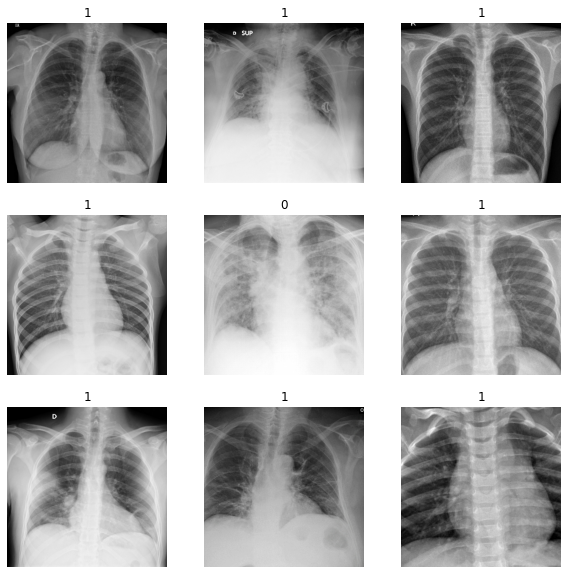

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (299, 299)
batch_size = 16
train_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true',
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true',
    crop_to_aspect_ratio=True
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
class_names = val_ds.class_names
print( "class_names: " + str( class_names ) )


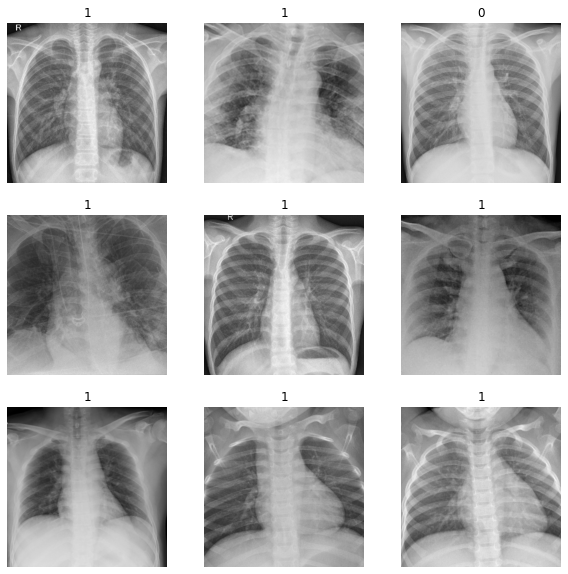

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
!pip install pydot
!pip install graphviz 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


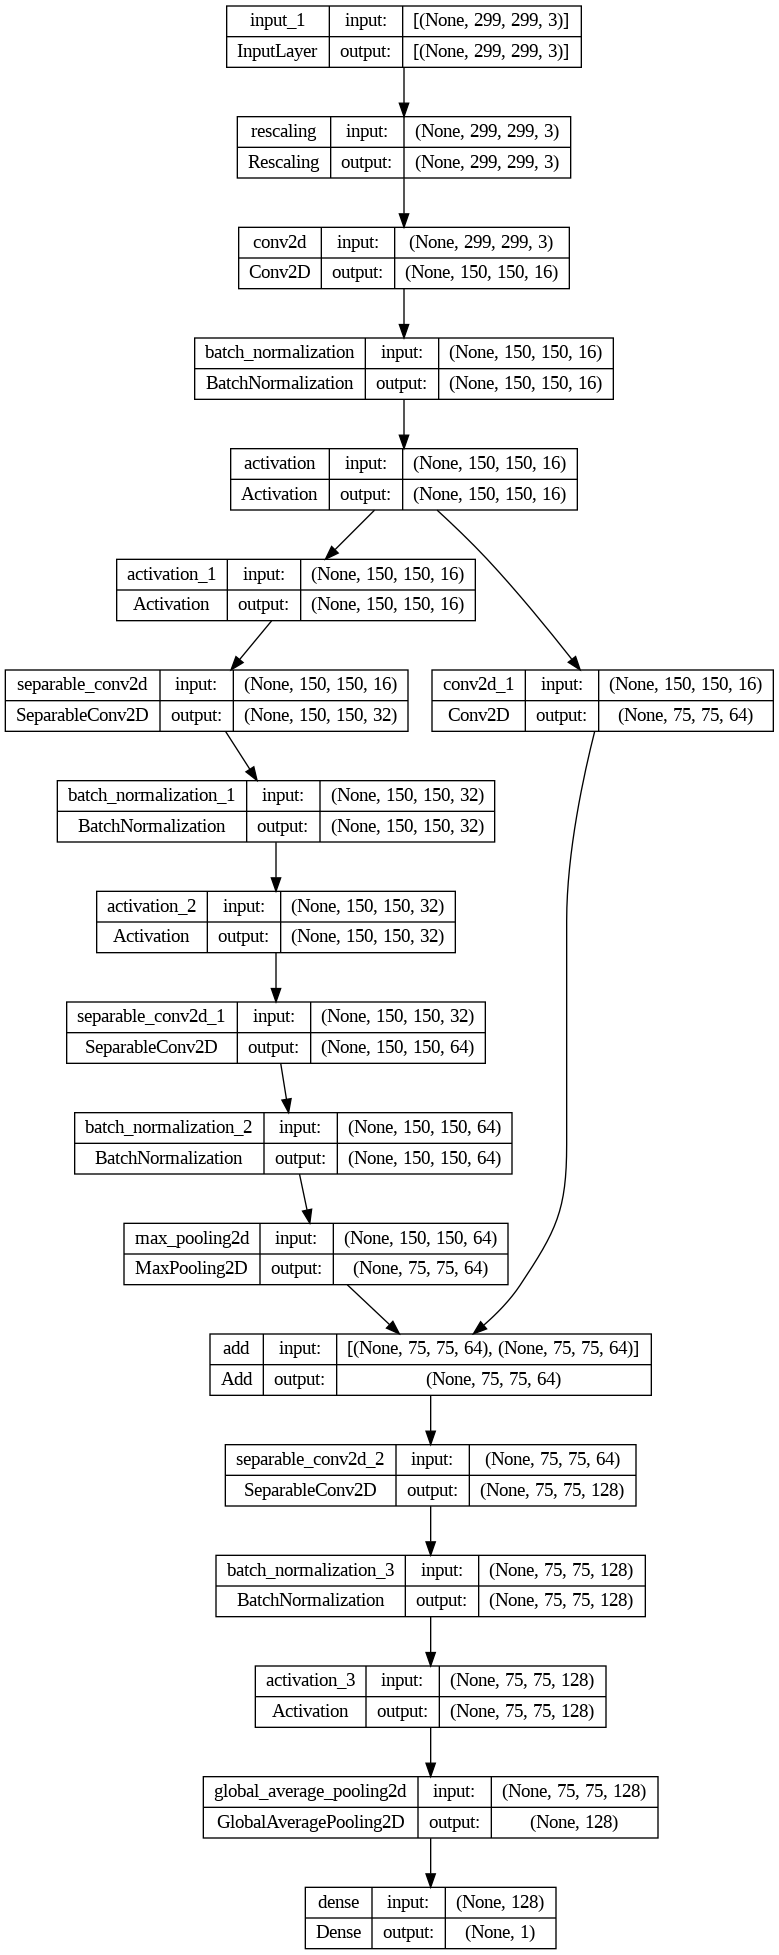

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(32, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

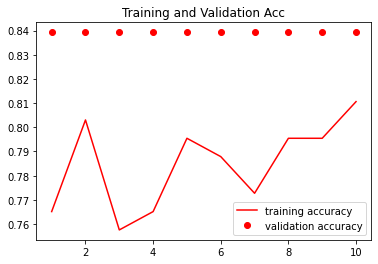

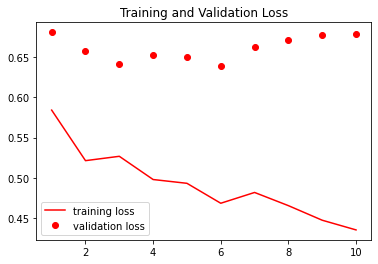

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
)
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.evaluate(val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/xray_covid19_dataset_model.h5')
print(history.history.keys())
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Transfer Learning Baseline Models

83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,960,681
Trainable params: 22,906,153
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
9/9 [==============================] - 12s 508ms/step - loss: 0.6366 - acc: 0.7424 - val_loss: 9.3863 - val_acc: 0.8393
Epoch 2/10
9/9 [==============================] - 3s 247ms/step - loss: 0.4449 - acc: 0.8106 - val_loss: 0.

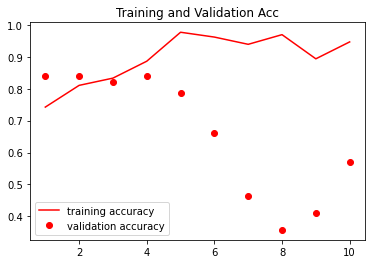

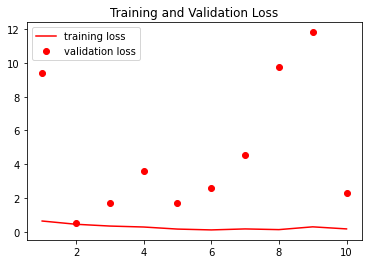

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(1024,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_xray_covid19_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,664,001
Trainable params: 25,618,561
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
9/9 [==============================] - 12s 544ms/step - loss: 1.1158 - acc: 0.6742 - val_loss: 51.5259 - val_acc: 0.8393
Epoch 2/10
9/9 [==============================] - 3s 252ms/step - loss: 0.4000 - acc: 0.7652 - val_loss:

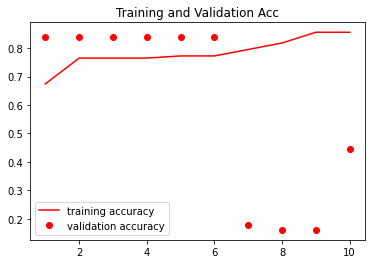

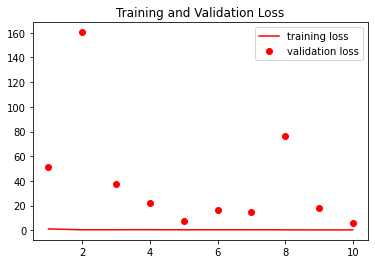

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(1024,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_xray_covid19_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

82420632/82420632 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 21,644,129
Trainable params: 21,490,257
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
9/9 [==============================] - 32s 959ms/step - loss: 0.5656 - acc: 0.6742 - val_loss: 0.5100 - val_acc: 0.8393
Epoch 2/10
9/9 [======================

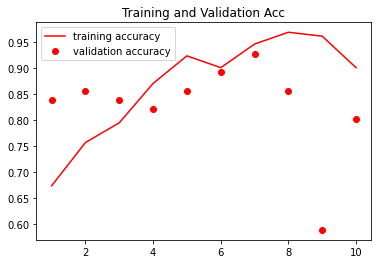

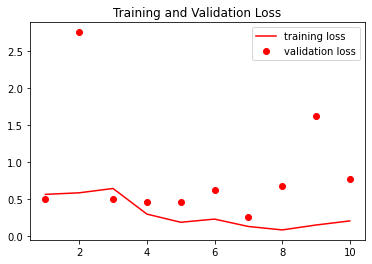

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(299,299,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(1024,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_xray_covid19_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#Augmented Models

Found 2148 files belonging to 2 classes.
Using 1504 files for training.
Found 40 files belonging to 2 classes.
Using 12 files for validation.
class_names: ['NORMAL', 'PNEUMONIA']


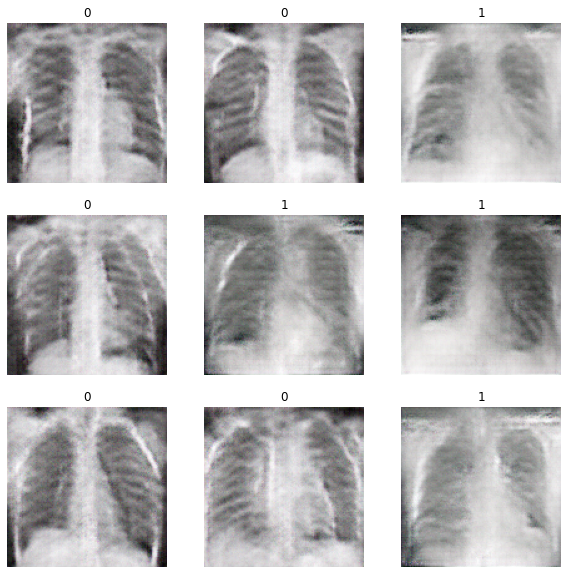

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (128, 128)
batch_size = 16
# here I decided to use the train / test folders since the dataset is limitied
# in size and if I used the normal split without specifying folderr I'd 
# essentially be testing models ability to discern gan images
train_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset + '/train', validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true',
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(xray_covid19_dataset + '/test', validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle='true',
    crop_to_aspect_ratio=True
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
class_names = val_ds.class_names
print( "class_names: " + str( class_names ) )


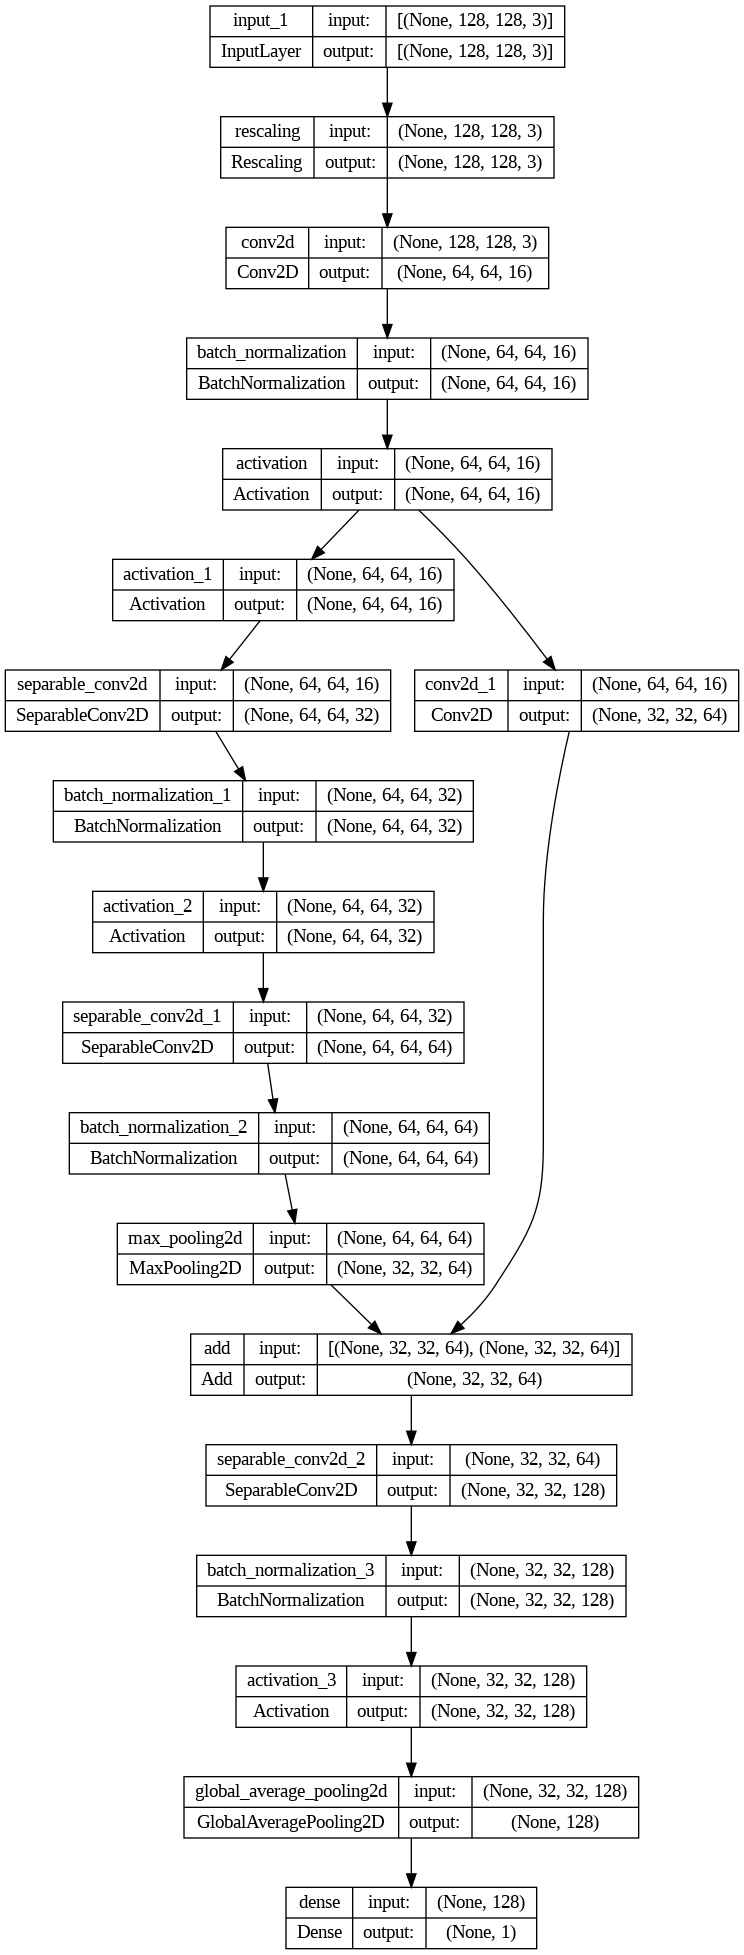

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    previous_block_activation = x  # Set aside residual

    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(32, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("swish")(x)
    x = layers.SeparableConv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.MaxPooling2D(2, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(64, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=1)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']             

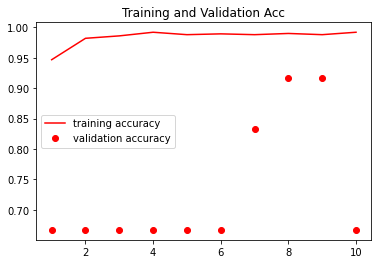

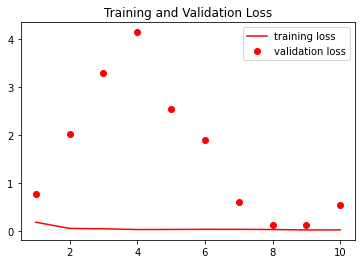

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
)
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.evaluate(val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/xray_covid19_dataset_model_augmented.h5')
print(history.history.keys())
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 22,960,681
Trainable params: 22,906,153
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 11s 59ms/step - loss: 0.0979 - acc: 0.9641 - val_loss: 0.2872 - val_acc: 0.9167
Epoch 2/10
94/94 [==============================] - 5s 47ms/step - loss: 0.0845 - acc: 0.9701 - val_loss: 

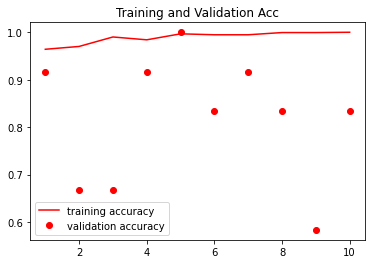

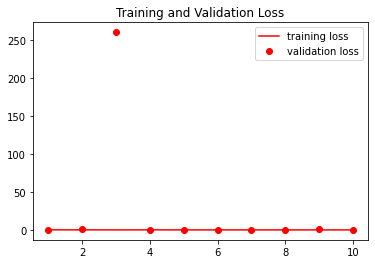

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(1024,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_xray_covid19_augmented_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_4 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,664,001
Trainable params: 25,618,561
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 12s 60ms/step - loss: 0.1468 - acc: 0.9654 - val_loss: 8.9571 - val_acc: 0.4167
Epoch 2/10
94/94 [==============================] - 5s 49ms/step - loss: 0.0326 - acc: 0.9854 - val_loss

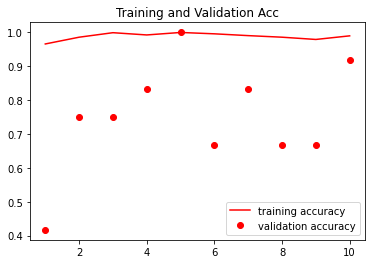

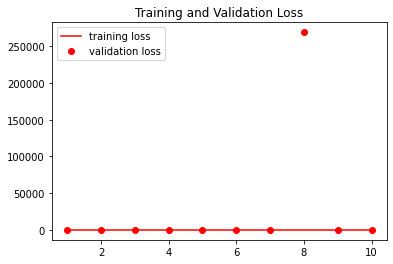

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(1024,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_xray_covid19_augmented_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


82420632/82420632 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 21,644,129
Trainable params: 21,490,257
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
94/94 [==============================] - 32s 121ms/step - loss: 0.1070 - acc: 0.9741 - val_loss: 3.6320 - val_acc: 0.6667
Epoch 2/10
94/94 [==================

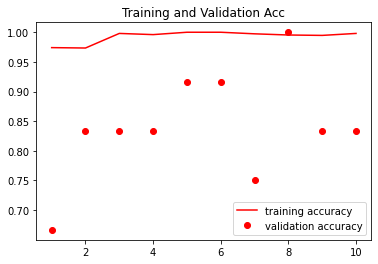

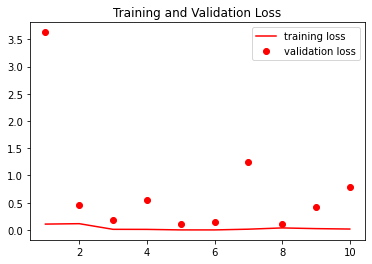

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(1024,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_xray_covid19_augmented_model.h5')

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
